In [52]:
# This is Exercise 01 for Lecture 07 (Ames Housing Part II - Feature Engineering) 
# of the "Data Science" class at Technische Hochschule Rosenheim

In [53]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from category_encoders import MEstimateEncoder
%matplotlib inline

In [54]:
# make the plots look nice
sns.set(style="darkgrid")
snscolor='mediumseagreen'
sns.set(font_scale=0.7) 

# The Ames Housing Dataset - Part II

## Load the cleaned data

In [55]:
columns_categorical = ['PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature',
       'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'SalePrice']
columns_discrete = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath',
                    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                    'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                    'MoSold', 'YrSold']
columns_continuous = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                      'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
                      '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
                      'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                      'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

columns_numeric =  columns_discrete + columns_continuous

In [56]:
# make lists of features
features_numeric = columns_numeric.copy()
features_numeric.remove('SalePrice') # remove target

features_categorical = columns_categorical.copy()

In [57]:
ames = pd.read_pickle("data/AmesHousingClean.pkl")
X = ames.copy()
y = X.pop("SalePrice")

#### Pre-defined Scoring Function

The following function can be used to evaluate the effects of your feature engineering efforts.

In [58]:
# use root mean squared error as scoring method.
# we will score our effort on both XGBoost Regression and Lasso Regression
def compute_score(X, y, text='Baseline'):
    score_xgb = -1 * cross_val_score(XGBRegressor(), X, y, cv=5, scoring="neg_root_mean_squared_error").mean()
    score_lr = -1 * cross_val_score(Lasso(tol=0.1, alpha=5), X, y, cv=5, scoring="neg_root_mean_squared_error").mean()
    print(f'{text:25}: xgb regression={score_xgb:,.0f} and lasso regression={score_lr:,.0f}')

In [59]:
# base line score - no hyperparameter tuning, using only numeric features as is
compute_score(X[features_numeric], y)

Baseline                 : xgb regression=28,093 and lasso regression=34,423


## Identifying important features

### Demo

To get a simple, explainable model, we want to use only 5 features as input. Let us identify the 5 numeric features that correlated the strongest with the target and compute the score using these 5 features only.

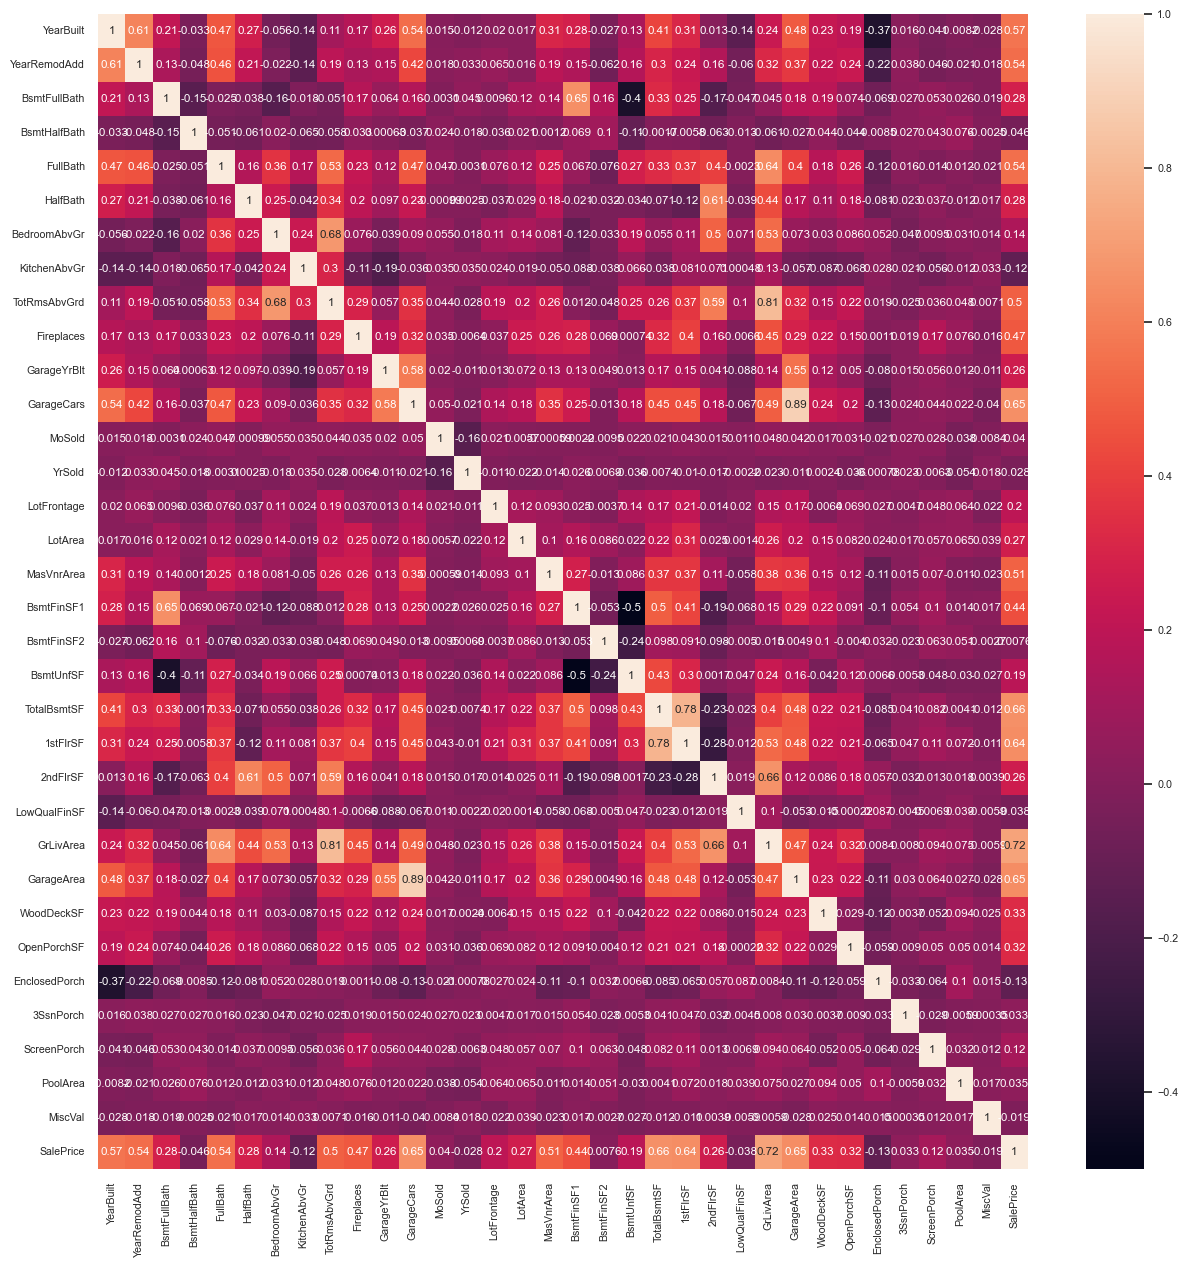

In [60]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(ames[columns_numeric].corr(), annot=True)
plt.show()

In [61]:
ames[columns_numeric].corr().SalePrice.sort_values(ascending=False)[1:6]

GrLivArea      0.719463
TotalBsmtSF    0.658863
GarageCars     0.652227
GarageArea     0.648050
1stFlrSF       0.642902
Name: SalePrice, dtype: float64

It would probably not be a good idea to use only these: 
1) the correlation goes down very slowly, so further features still have a strong correlation.
2) some of these features are very strongly correlated with each other, e.g. GarageCars and GarageArea - using only one of them would probably be sufficient.

In [62]:
compute_score(X[features_numeric], y)
compute_score(X[['GrLivArea', 'TotalBsmtSF', 'GarageCars', 'GarageArea', '1stFlrSF']], y, 'MaxCorrFeatures:')

Baseline                 : xgb regression=28,093 and lasso regression=34,423
MaxCorrFeatures:         : xgb regression=39,250 and lasso regression=40,742


Let us pick our own set of 5 features based on domain knowledge and the correlation matrix, compute the score and compare it with the scores before.

We should definitly use the `GrLivArea`. The `TotalBsmtSF` does not correlated very strongly with it, so let's include this as well. The number of cars fitting inside the garage is probably more important than the area of the garage, and these two correlated strongly, so let's include `GarageCars` and exclude `GarageArea`. To get some more variety in the features, let's include the `YearBuilt` and the number of full bathrooms `FullBath`, both should correlated with the target.

In [63]:
compute_score(X[features_numeric], y)
compute_score(X[['GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt', 'FullBath']], y, 'Our Selection:')

Baseline                 : xgb regression=28,093 and lasso regression=34,423
Our Selection:           : xgb regression=33,380 and lasso regression=37,513


Interpretation: this is considerably better than simply using the features with the highest correlation, but still considerably worse then using all features (as should be expected)

## One-Hot Encoding categorical variables

To improve our model, we decided to add in two categorical variables: the overall condition of the property `OverallCond` and the Neighborhood `Neighborhood`.

### Exercise II.1

* Use one-hot encoding for the `OverallCond`. Use the `pandas` function `get_dummies`. Call the new DataFrame `X_OHE` including all original features plus the one-hot-encoded `OverallCond`
* Evaluate the score and compare to the base-line-score.

In [64]:
#---------- SOLUTION ----------
print(X.shape)
X_OHE = pd.get_dummies(X, columns=["OverallCond"], drop_first=True)
X_OHE

(2925, 80)


,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9
Order,,,,,,,,,,,,,,,,,,,,,
1,0526301100,020,RL,141.0,31770.0,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,False,False,False,True,False,False,False,False
2,0526350040,020,RH,80.0,11622.0,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,False,False,False,False,True,False,False,False
3,0526351010,020,RL,81.0,14267.0,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,False,False,False,False,True,False,False,False
4,0526353030,020,RL,93.0,11160.0,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,False,False,False,True,False,False,False,False
5,0527105010,060,RL,74.0,13830.0,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,0923275080,080,RL,37.0,7937.0,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,False,False,False,False,True,False,False,False
2927,0923276100,020,RL,0.0,8885.0,Pave,NA,IR1,Low,AllPub,...,WD,Normal,False,False,False,True,False,False,False,False
2928,0923400125,085,RL,62.0,10441.0,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,False,False,False,True,False,False,False,False


In [65]:
compute_score(X_OHE[features_numeric], y)
pd.concat([X[features_numeric], X_OHE.filter(like="OverallCond")], axis=1)
compute_score(pd.concat([X_OHE[features_numeric], X_OHE.filter(like="OverallCond")], axis=1), y, 'Our Selection:')

Baseline                 : xgb regression=28,093 and lasso regression=34,423
Our Selection:           : xgb regression=27,321 and lasso regression=33,267


## Target-Encoding categorical variables

Let us use target encoding for the `Neighborhood` feature. It has the most categories of any feature, and several categories are rare.

In [66]:
ames["Neighborhood"].value_counts()

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    191
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64

You will remember from class, that we need to compute the target encoding on a separate split of data in order to avoid target leakage. So, let's split the data into the `encode` split and the rest, which will become the training set by adding the encoded neighborhood features.

In [67]:
# Encoding split - let's use 10 % of the data for encoding
X_encode = ames.sample(frac=0.1, random_state=0)
y_encode = X_encode.pop('SalePrice')

# Training split - the rest
X_pretrain = ames.drop(X_encode.index)
y_train = X_pretrain.pop('SalePrice')

### Exercise II.2

* Fit an `MEstimateEncoder` for the `Neighborhood` column with an `m=2.0`. Transform the pretrain-split using this encoder. 
* Include the target encoded Neighborhood with the other numeric features of the base model and compare the score. Interpret your result.

Tip: you can find the documentation for the `MEstimateEncoder` at http://contrib.scikit-learn.org/category_encoders/mestimate.html.

In [69]:
#---------- SOLUTION ----------
encoder = MEstimateEncoder(cols=["Neighborhood"], m=2)

encoder.fit(X_encode, y_encode)

X_train = encoder.transform(X_pretrain, y_train)

In [ ]:
features_numeric_neighbourhood

## Scaling

Especially linear regression with regularization is very sensitive to different magnitudes of the input features. We will try to improve our model by scaling all input features.

### Exercise II.3

* Use the `StandardScaler` to scale all features of the base model
* Score your results and compare to the base model.

In [ ]:
#---------- SOLUTION ----------

### Exercise II.4

Let's combine target encoding of the Neighborhood and scaling: 

* Use the `StandardScaler` to scale all features incl. the target encoded Neighborhood
* Score your results and compare to the non-scaled model.

In [ ]:
#---------- SOLUTION ----------

------